In [4]:
%%bash
# Colab-specific setup
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
pip install yacs 2>&1 >> install.log
git init 2>&1 >> install.log
git remote add origin https://github.com/jeongrok/semantic-segmentation-pytorch.git 2>> install.log
git pull origin master 2>&1 >> install.log
DOWNLOAD_ONLY=1 ./demo_test.sh 2>> install.log

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
From https://github.com/jeongrok/semantic-segmentation-pytorch
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


In [42]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')

    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))

## Loading the segmentation model

Here we load a pretrained segmentation model.  Like any pytorch model, we can call it like a function, or examine the parameters in all the layers.

After loading, we put it on the GPU.  And since we are doing inference, not training, we put the model in eval mode.

In [ ]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cuda()

## Load test data

Now we load and normalize a single test image.  Here we use the commonplace convention of normalizing the image to a scale for which the RGB values of a large photo dataset would have zero mean and unit standard deviation.  (These numbers come from the imagenet dataset.)  With this normalization, the limiiting ranges of RGB values are within about (-2.2 to +2.7).

In [31]:
# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])
pil_image = PIL.Image.open('our_data/Test/33012f501af95eecd41803710646e57e87c2680d.jpg').convert('RGB')
img_original = numpy.array(pil_image)
img_data = pil_to_tensor(pil_image)
singleton_batch = {'img_data': img_data[None].cuda()}
output_size = img_data.shape[1:]

## Run the Model

Finally we just pass the test image to the segmentation model.

The segmentation model is coded as a function that takes a dictionary as input, because it wants to know both the input batch image data as well as the desired output segmentation resolution.  We ask for full resolution output.

Then we use the previously-defined visualize_result function to render the segmentation map.

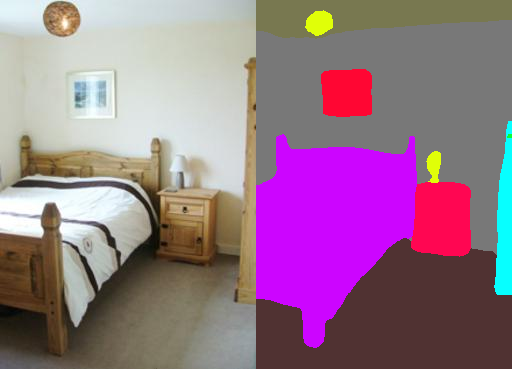

In [32]:
# Run the segmentation at the highest resolution.
with torch.no_grad():
    scores = segmentation_module(singleton_batch, segSize=output_size)

# Get the predicted scores for each pixel
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()
visualize_result(img_original, pred)

## Showing classes individually

To see which colors are which, here we visualize individual classes, one at a time.

wall:


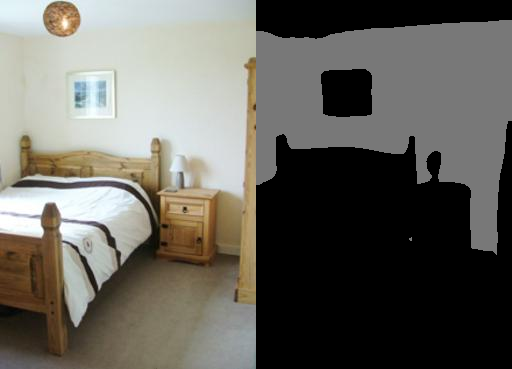

floor:


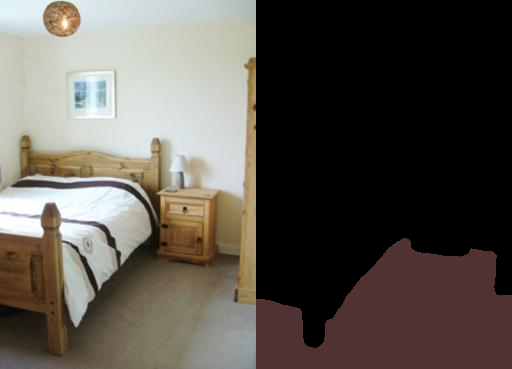

bed:


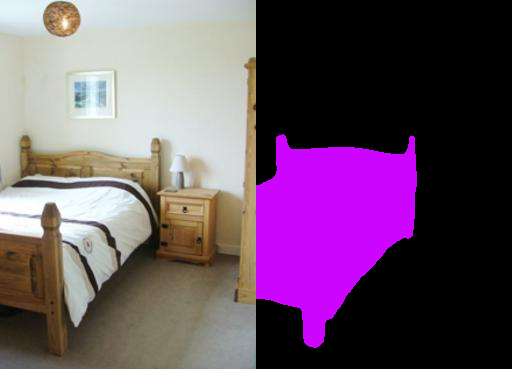

ceiling:


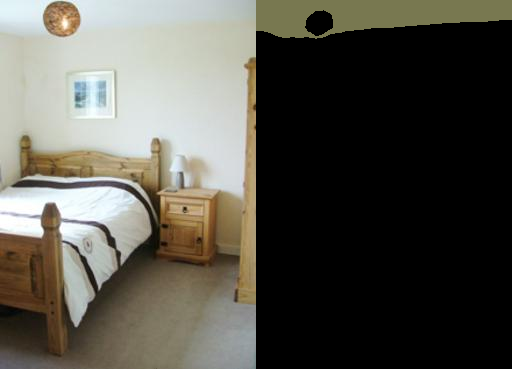

table:


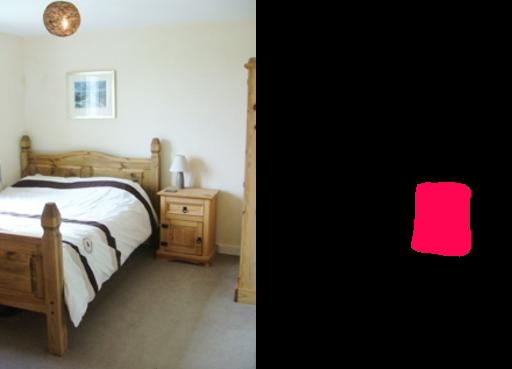

painting:


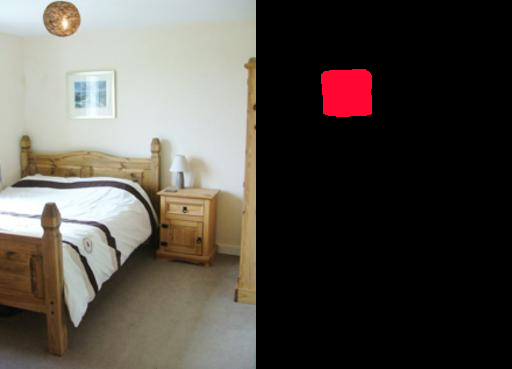

wardrobe:


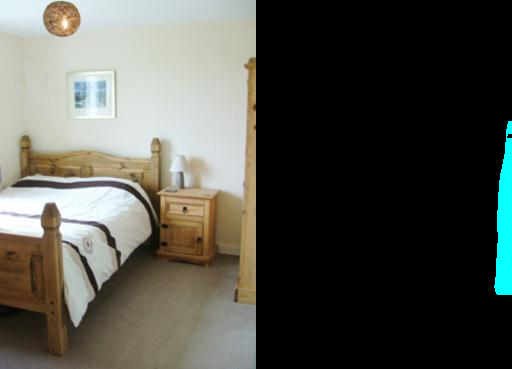

lamp:


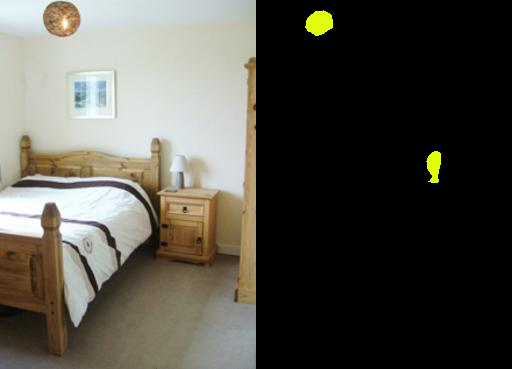

door:


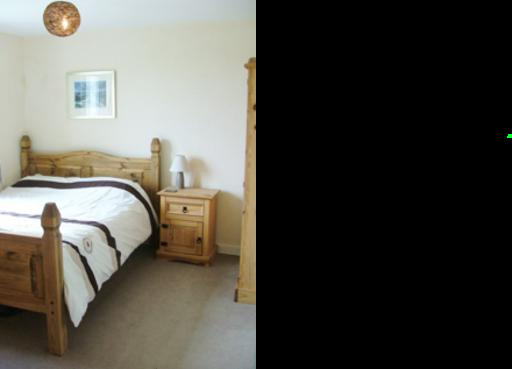

earth:


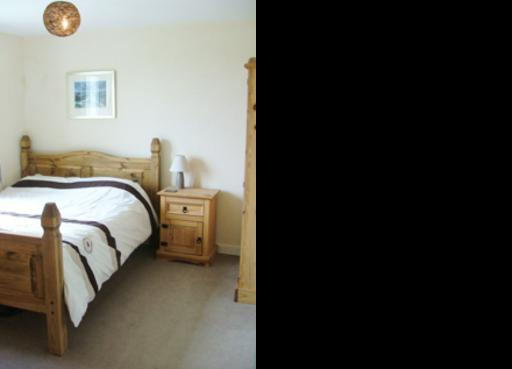

building:


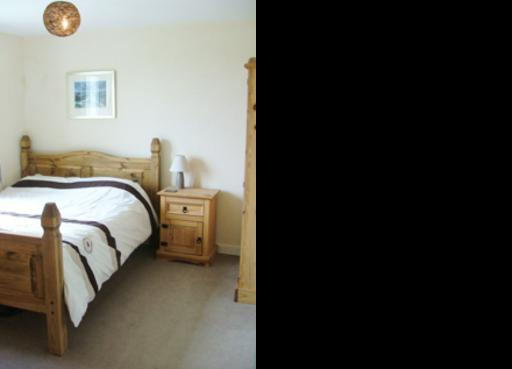

sky:


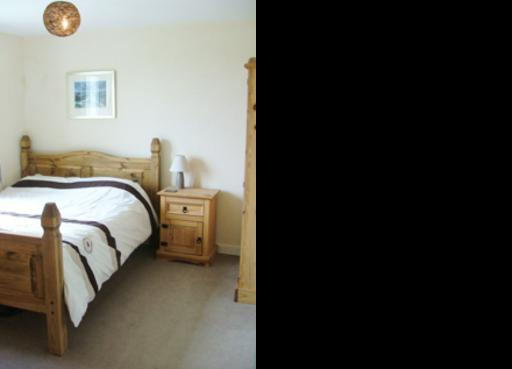

rock:


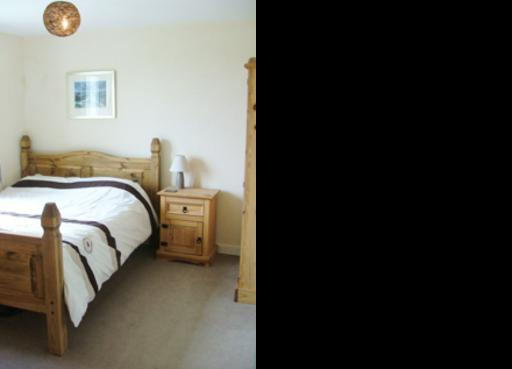

tree:


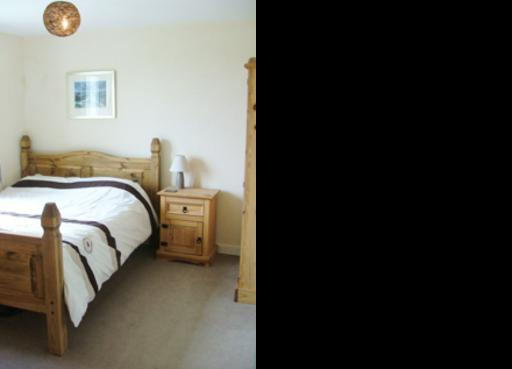

desk:


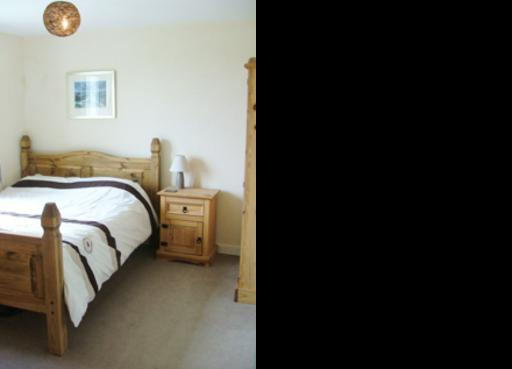

In [43]:
# Top classes in answer
predicted_classes = numpy.bincount(pred.flatten()).argsort()[::-1]
for c in predicted_classes[:15]:
    visualize_result(img_original, pred, c)

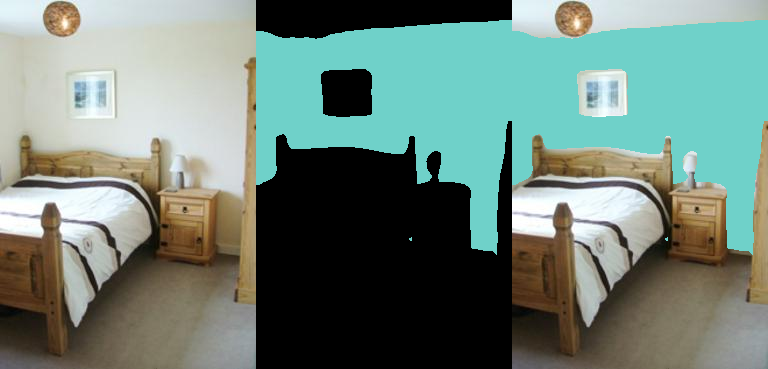

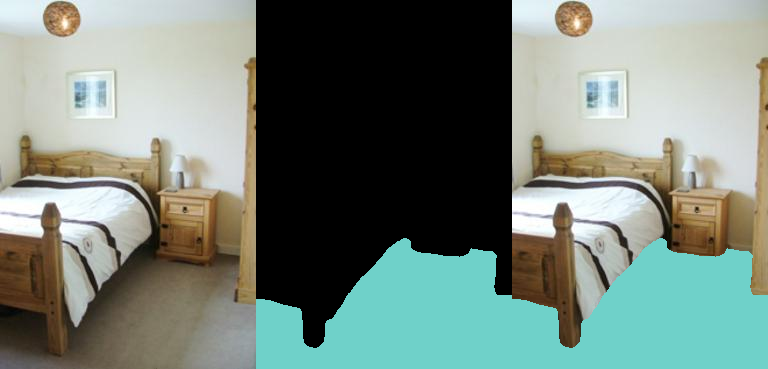

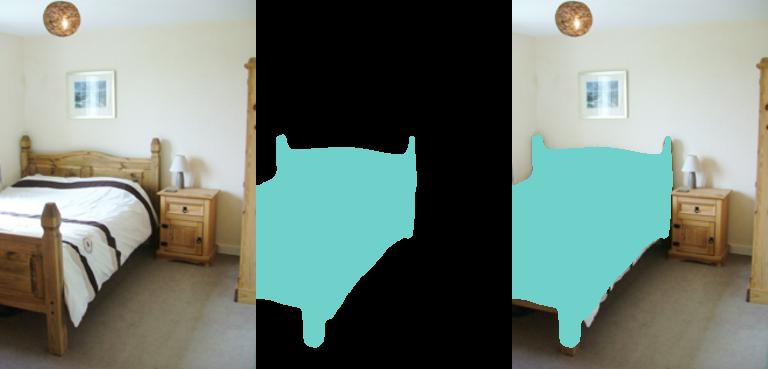

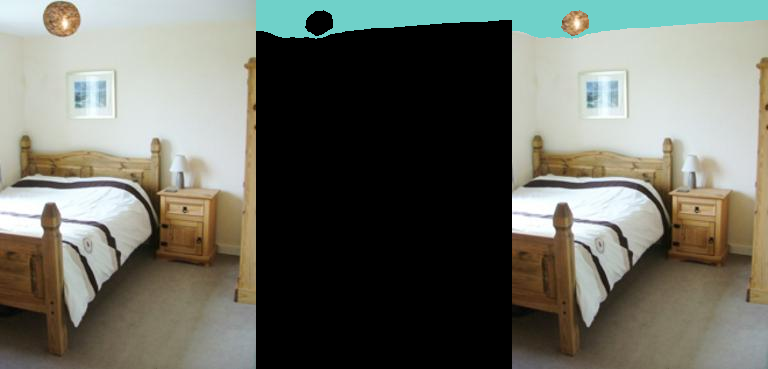

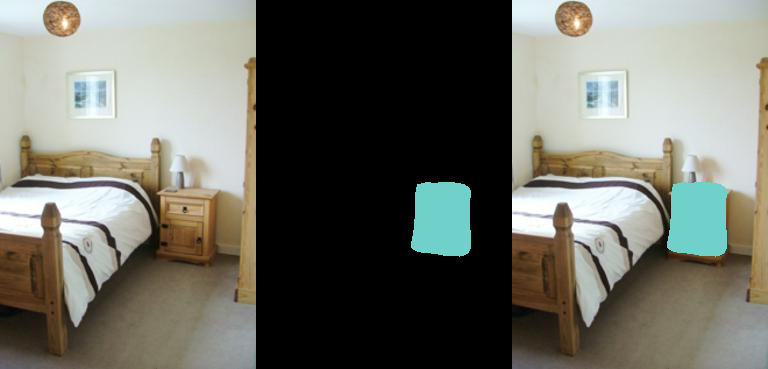

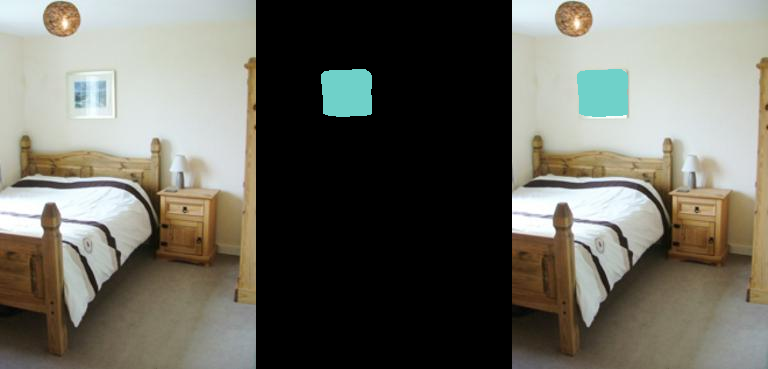

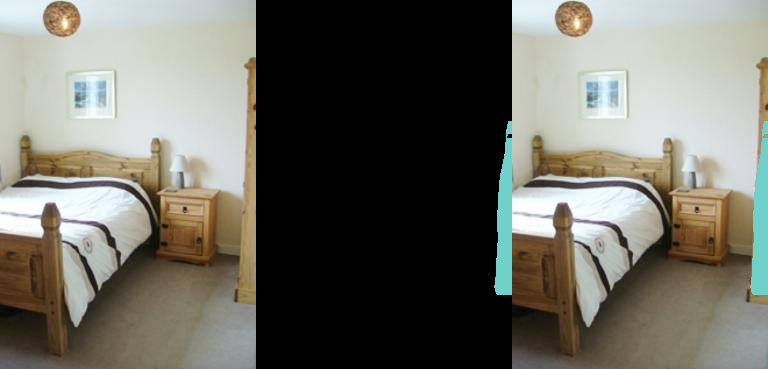

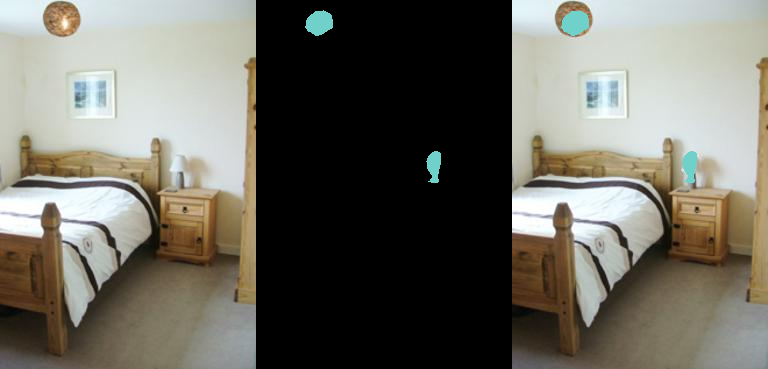

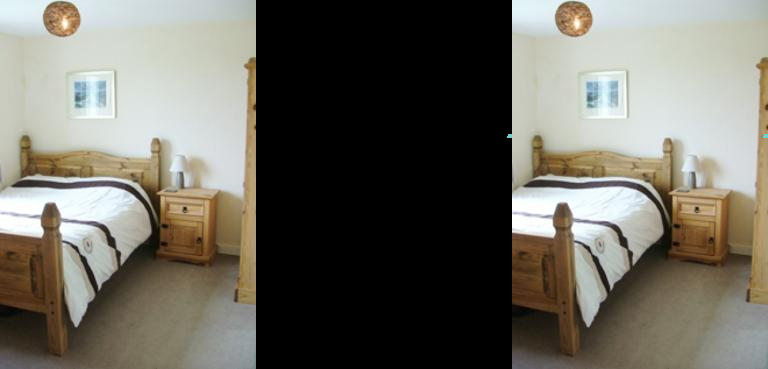

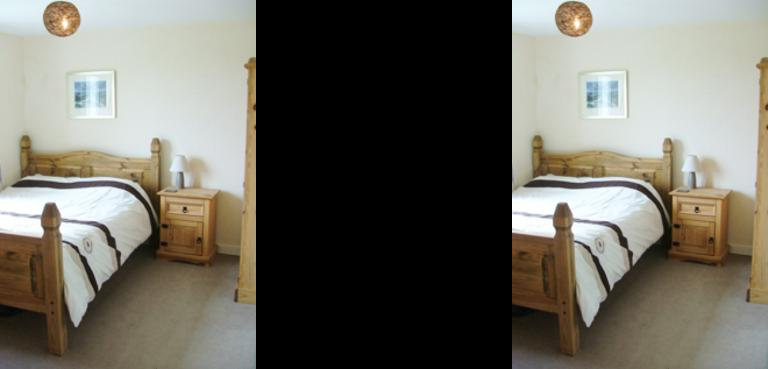

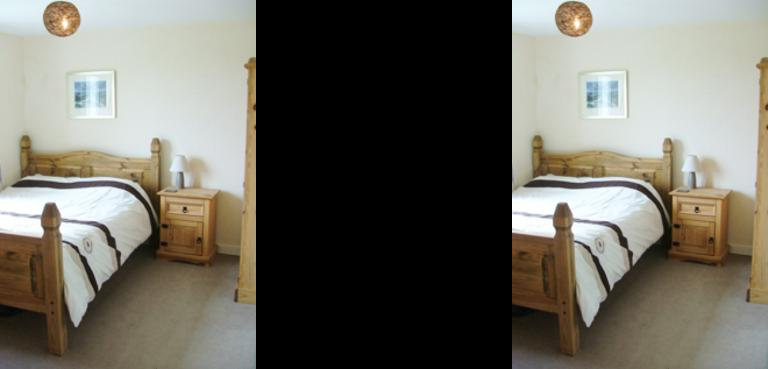

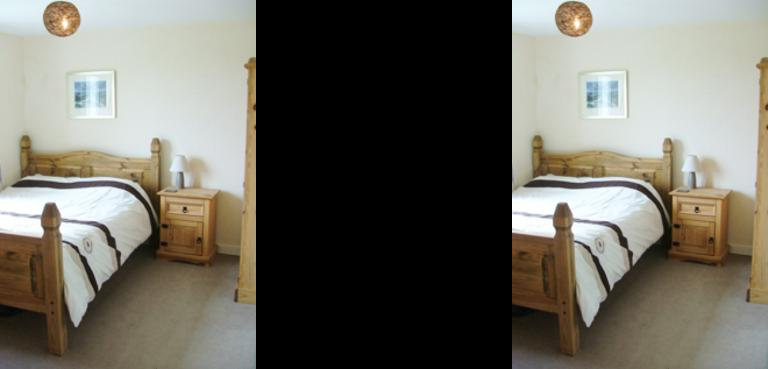

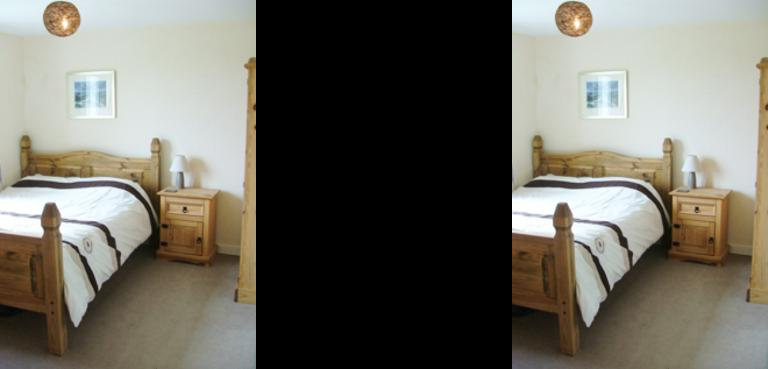

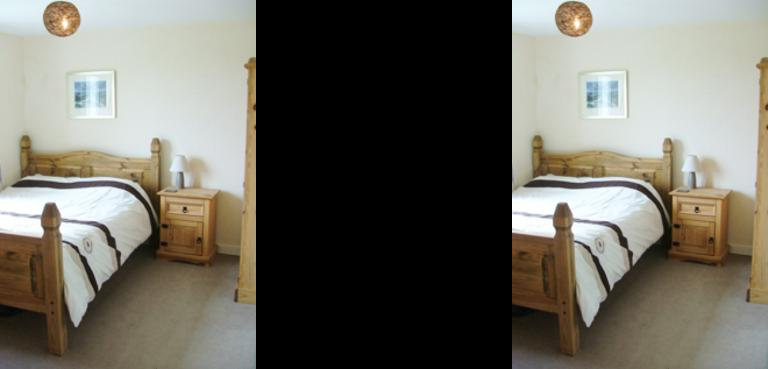

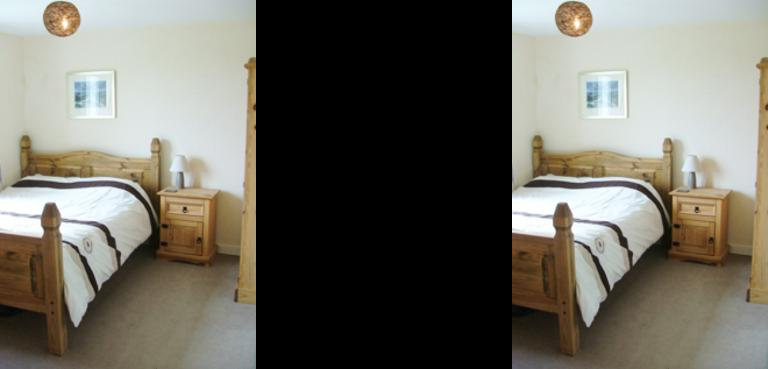

In [51]:
def visualize_wall(img, pred, class_to_display=0):
    """
        Function for visualizing wall prediction
        (original image, segmentation mask and original image with the segmented wall)
    """
    img_green = img.copy()
    black_green = img.copy()
    img_green[pred == class_to_display] = [111, 209, 201]
    black_green[pred == class_to_display] = [111, 209, 201]
    black_green[pred != class_to_display] = [0, 0, 0]
    im_vis = np.concatenate((img, black_green, img_green), axis=1)
    display(PIL.Image.fromarray(im_vis))

predicted_classes = numpy.bincount(pred.flatten()).argsort()[::-1]
for c in predicted_classes[:15]:
    visualize_wall(img_original, pred, c)